<a href="https://colab.research.google.com/github/umar178/AI-Infrastructure/blob/main/Urdu_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing required libraries
!pip install transformers torch pandas numpy scikit-learn datasets kagglehub accelerate evaluate


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TextClassificationPipeline,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
import torch
import glob
import evaluate  # For loading metrics

E:\Github\AI-Infrastructure\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Create project structure
project_dir = "/content/urdu-sentiment-analysis"
os.makedirs(project_dir, exist_ok=True)

subdirs = [
    "data/raw",
    "data/processed",
    "models/fine_tuned_model",
    "utils",
    "notebooks"
]

for subdir in subdirs:
    os.makedirs(os.path.join(project_dir, subdir), exist_ok=True)

%cd {project_dir}

E:\content\urdu-sentiment-analysis


E:\Github\AI-Infrastructure\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import kagglehub
import glob
import shutil
import os

# Define your project_dir if not already set
project_dir = "C:/path/to/your/project"  # <-- change this to your actual project folder

# Download dataset
path = kagglehub.dataset_download("akkefa/imdb-dataset-of-50k-movie-translated-urdu-reviews")
csv_files = glob.glob(f"{path}/**/*.csv", recursive=True)

if csv_files:
    csv_file_path = csv_files[0]
    dest_path = os.path.join(project_dir, "data", "raw", "IMDB_Urdu_Reviews.csv")

    # Make sure directory exists
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)

    # Copy the file
    shutil.copy(csv_file_path, dest_path)
    print(f"Copied {csv_file_path} to {dest_path}")
else:
    print("No CSV files found.")


Copied C:\Users\Haider\.cache\kagglehub\datasets\akkefa\imdb-dataset-of-50k-movie-translated-urdu-reviews\versions\6\imdb_urdu_reviews_test.csv to C:/path/to/your/project\data\raw\IMDB_Urdu_Reviews.csv


In [5]:
# Load and prepare data
df = pd.read_csv('data/raw/IMDB_Urdu_Reviews.csv')
df = df.dropna()
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/IMDB_Urdu_Reviews.csv'

In [6]:
# Load tokenizer and model
model_name = "Aimlab/xlm-roberta-base-finetuned-urdu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: 'negative', 1: 'positive'},
    label2id={'negative': 0, 'positive': 1}
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/770 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [7]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["review"],
        truncation=True,
        max_length=512,
        padding=False
    )

# Convert to datasets
train_dataset = Dataset.from_pandas(train_df[['review', 'label']])
val_dataset = Dataset.from_pandas(val_df[['review', 'label']])
test_dataset = Dataset.from_pandas(test_df[['review', 'label']])

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [8]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=100,
    report_to="none"
)

# Metric function using evaluate
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-3232194403.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [9]:
# Fine-tune the model
print("Starting fine-tuning...")
trainer.train()

# Save the fine-tuned model
trainer.save_model(f"{project_dir}/models/fine_tuned_model")
tokenizer.save_pretrained(f"{project_dir}/models/fine_tuned_model")
print("Fine-tuned model saved!")

Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.377900,0.344998,0.867250
2,0.274300,0.387961,0.903750
3,0.297600,0.421190,0.903000


Fine-tuned model saved!


Evaluating on the test set...


Test accuracy: 0.8642

Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.95      0.77      0.85      2012
    positive       0.80      0.96      0.88      1988

    accuracy                           0.86      4000
   macro avg       0.88      0.86      0.86      4000
weighted avg       0.88      0.86      0.86      4000



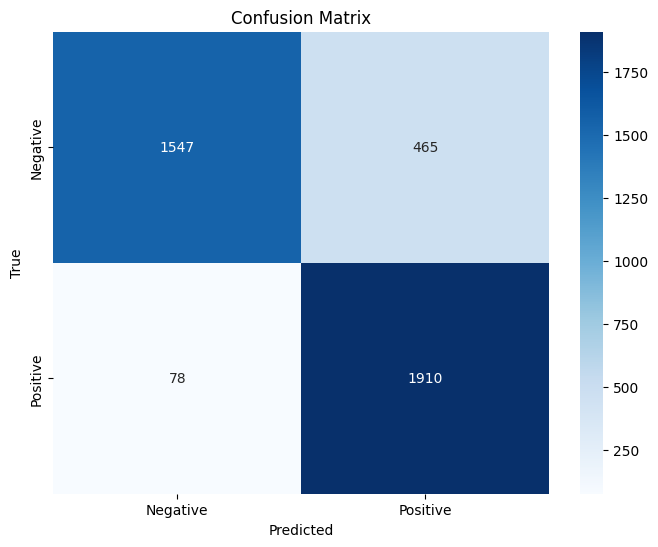

Detailed test results saved!
Performance summary saved!


In [10]:
# Evaluate on the test set
print("Evaluating on the test set...")
test_predictions = trainer.predict(tokenized_test)
test_metrics = test_predictions.metrics
print(f"Test accuracy: {test_metrics['test_accuracy']:.4f}")

# Get predicted labels
import numpy as np
predicted_labels = np.argmax(test_predictions.predictions, axis=1)
true_labels = test_df['label'].values

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['negative', 'positive']))

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(f'{project_dir}/confusion_matrix.png')
plt.show()

# Save test results to a comprehensive report
results_df = test_df.copy()
results_df['predicted'] = predicted_labels
results_df['predicted_sentiment'] = results_df['predicted'].map({0: 'negative', 1: 'positive'})

# For confidence scores, we need to apply softmax to the predictions
from scipy.special import softmax
results_df['confidence'] = [max(softmax(pred)) for pred in test_predictions.predictions]

# Calculate correct predictions
results_df['correct'] = results_df['sentiment'] == results_df['predicted_sentiment']

# Save detailed results
results_df.to_csv(f'{project_dir}/data/processed/detailed_test_results.csv', index=False)
print("Detailed test results saved!")

# Create a performance summary
performance_summary = {
    'model': 'Fine-tuned XLM-RoBERTa for Urdu Sentiment Analysis',
    'dataset': 'IMDB Urdu Movie Reviews',
    'train_samples': len(train_df),
    'validation_samples': len(val_df),
    'test_samples': len(test_df),
    'test_accuracy': test_metrics['test_accuracy'],
    'epochs': 3
}

# Save performance summary
import json
with open(f'{project_dir}/performance_summary.json', 'w') as f:
    json.dump(performance_summary, f, indent=4)

print("Performance summary saved!")

In [11]:
# Create prediction pipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(
    f"{project_dir}/models/fine_tuned_model"
).to(device)

fine_tuned_tokenizer = AutoTokenizer.from_pretrained(
    f"{project_dir}/models/fine_tuned_model"
)

fine_tuned_pipe = TextClassificationPipeline(
    model=fine_tuned_model,
    tokenizer=fine_tuned_tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

# Test with sample text
sample_text = "یہ فلم بہت زبردست تھی"
result = fine_tuned_pipe(sample_text)
print(f"Sample prediction: {result}")

Device set to use cuda:0


Sample prediction: [{'label': 'positive', 'score': 0.9748280644416809}]


In [12]:
# Create helper functions
utils_content = '''
import pandas as pd
import numpy as np
from transformers import TextClassificationPipeline

def predict_sentiment(text, pipeline):
    """
    Predict sentiment for a single text
    """
    result = pipeline(text, truncation=True, max_length=512)
    return max(result[0], key=lambda x: x['score'])

def batch_predict(texts, pipeline, batch_size=16):
    """
    Predict sentiment for multiple texts with batching and truncation
    """
    predictions = []

    # Process in batches to avoid memory issues
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        try:
            results = pipeline(batch, truncation=True, max_length=512)
            for result in results:
                pred = max(result, key=lambda x: x['score'])
                predictions.append({
                    'label': pred['label'],
                    'score': pred['score']
                })
        except Exception as e:
            print(f"Error processing batch {i//batch_size}: {e}")
            # Add neutral predictions for failed batches
            for _ in range(len(batch)):
                predictions.append({
                    'label': 'neutral',
                    'score': 0.5
                })

    return predictions

def save_predictions(df, predictions, output_path):
    """
    Save predictions to a CSV file
    """
    results_df = df.copy()
    results_df['predicted_label'] = [p['label'] for p in predictions]
    results_df['confidence_score'] = [p['score'] for p in predictions]
    results_df.to_csv(output_path, index=False)
    return results_df

def preprocess_text(text, max_length=400):
    """
    Simple text preprocessing to handle long texts
    """
    # Truncate very long texts by words
    words = text.split()
    if len(words) > max_length:
        text = " ".join(words[:max_length])
    return text
'''

with open(os.path.join(project_dir, 'utils/helpers.py'), 'w') as f:
    f.write(utils_content)

print("Helpers file created successfully")

# Create requirements.txt
requirements_content = '''
torch>=1.9.0
transformers>=4.12.0
pandas>=1.3.0
numpy>=1.21.0
scikit-learn>=0.24.0
datasets>=1.12.0
kagglehub>=0.1.0
accelerate>=0.20.0
evaluate>=0.4.0
'''

with open(os.path.join(project_dir, 'requirements.txt'), 'w') as f:
    f.write(requirements_content)



Helpers file created successfully


In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


CUDA available: False
Device: cpu
